In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
def get_initial(size,seed=42):
    np.random.seed(seed)
    s=""
    for i in range(size):
        s+=np.random.choice(["R","P","S"])
    return s


In [23]:

class Bot():
    def __init__(self,strategy) -> None:
        self.strategy=strategy
        if self.strategy=="kris":
            self.history=["R"]
        if self.strategy=="mrugesh":
            self.history=["R" for i in range(10)]
        if self.strategy=="quincy":
            self.history=[]
        if self.strategy=="abbey":
            self.history=["R","R"]
            self.play_order={
                "RR": 0,
                "RP": 0,
                "RS": 0,
                "PR": 0,
                "PP": 0,
                "PS": 0,
                "SR": 0,
                "SP": 0,
                "SS": 0,
          }
    
    def play(self,context):
        s=""
        if self.strategy=="mrugesh":
            for i in range(len(context)):
                s=s+self._mrugesh()
                self.update_history(context[i])
            
        elif self.strategy=="kris":
            for i in range(len(context)):
                s=s+self._kris()
                self.update_history(context[i])
            
        elif self.strategy=="quincy":
            for i in range(len(context)):
                s=s+self._quincy()
                self.update_history(context[i])
        elif self.strategy=="abbey":
            for i in range(len(context)):
                s=s+self._abbey()
                self.update_history(context[i])
        return s

    def update_history(self,move):
        self.history.append(move)

    def _mrugesh(self):
        last_ten=self.history[-10:]
        most_frequent = max(set(last_ten), key=last_ten.count)

        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[most_frequent]
    
    def _kris(self):
        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[self.history[-1]]
    
    def _quincy(self): #дает одни и теже ответы по кругу
        choices=["R","R","P","P","S"]

        return choices[len((self.history))%len(choices)]
    
    def _abbey(self): # выбирает самое популярное сочетание ходов и отвечает на него
        last_two="".join(self.history[-2:])
        self.play_order[last_two] += 1

        potential_plays = [
            self.history[-1] + "R",
            self.history[-1] + "P",
            self.history[-1] + "S",
        ]

        sub_order = {k: self.play_order[k] for k in potential_plays if k in self.play_order}

        prediction = max(sub_order, key=sub_order.get)[-1:]

        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}

        return ideal_response[prediction]




In [24]:
def get_antipos(context):
        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        ans=""
        for i in context:
            ans=ans+ideal_response[i]
        return ans

def prepare_sequence(seq, to_ix):
        idxs = [to_ix[ch] for ch in seq]
        return torch.tensor(idxs, dtype=torch.long)

def decode(x):
    _={"R":0,"P":1,"S":2}
    return _[x]

def encode(x):
    _={0:"R",1:"P",2:"S"}
    return _[x]

def decide_winner(x,y,decoded=True):
    if decoded:
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1
    else:
        x,y=decode(x),decode(y)
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1



In [25]:
def create(EMBEDDING_DIM=3,HIDDEN_DIM=64,architecture="lstm"):
    #architecture-lstm, rnn : to do- gru

    # Создаем словарь символов
    chars = sorted(set("RPS"))
    
    
    # Архитектура модели LSTM
    class TextGenerator(nn.Module):
        def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size,architecture):
            super(TextGenerator, self).__init__()
            self.hidden_dim = hidden_dim
    
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
            if architecture=="lstm":
                self.text = nn.LSTM(embedding_dim, hidden_dim)
            elif architecture=="rnn":
                self.text = nn.RNN(embedding_dim, hidden_dim)
            self.hidden = nn.Linear(hidden_dim, output_size)
            
        def forward(self, sentence):
            embeds = self.word_embeddings(sentence)
            text_out, _ = self.text(embeds.view(len(sentence), 1, -1))
            hidden = self.hidden(text_out.view(len(sentence), -1))
            
            return hidden
    
    # Подготовка данных и создание модели
    
    return TextGenerator(EMBEDDING_DIM, HIDDEN_DIM, len(chars), len(chars),architecture)
    
    
    

def fit(model,EPOCHS=2000,optimm="adam",loss="cross_entropy",bot_strategy="mrugesh",games_ahead=8,verbose=True):
    
    chars = sorted(set("RPS"))
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for i, ch in enumerate(chars)}


    if loss=="cross_entropy":
        loss_function = nn.CrossEntropyLoss()
    if optimm=="adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Обучение модели
    
    history="R"*(games_ahead+1) #initial history ,играет бот

    bot=Bot(strategy=bot_strategy)
    
    loss_history=[]
    for epoch in range(EPOCHS):
        model.train()
        
        #батча как такового нет ,есть количество игр которые наперед играет агент
        
        inputs = prepare_sequence(history[-games_ahead-1:-1], char_to_ix)
        targets = prepare_sequence(history[-games_ahead:], char_to_ix)  # Предсказание следующего символа
        
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
    
    
        #предсказали->перевернули-> записали ответ
        outputs_str=""
        for i in range(games_ahead):
            output_dist = F.softmax(outputs[i], dim=0)
            top_i = torch.argmax(output_dist).item()
            outputs_str += ix_to_char[top_i]
            
    
        history=history+bot.play(get_antipos(outputs_str))
        
        loss_history.append(loss.item())
        if verbose and (epoch+1) % 200 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    

    if verbose:
        plt.plot([i for i in range(EPOCHS)],loss_history)
        plt.show()
    
    return model,loss_history


In [53]:

def eval(model, bot,epochs=1000,enable_random=False,low_winrate=0.6, frequency=25):
    # enable_random=True-при маленьком винрейте иногда начинает делать рандомные ходы
    # low_winrate - при каком винрейте начинать делам рандомные ходы , используется только при low_winrate==True
    # frequency- как часто при низком винрейте делать рандомные ходы , используется только при low_winrate==True
    model.train()

    chars = sorted(set("RPS"))
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for i, ch in enumerate(chars)}

    actual_history="RPSRPSRPS" #history of bot moves
    generated=actual_history
    hidden = None
    last_player_move=get_antipos(generated[-1])

    stats={"player_wins":0,"bot_wins":0,"tie":0}

    win_or_lose="1"*9

    winrate=1
    for epoch in range(1,epochs+1):  
        input = prepare_sequence(actual_history, char_to_ix)
        output = model(input)
        output_dist = F.softmax(output[-1], dim=0)
        top_i = torch.argmax(output_dist).item()
        generated += ix_to_char[top_i]
        #предсказали->перевернули->записали ответ
        if enable_random==True and winrate<low_winrate and epoch%frequency==0:
                player_move=np.random.choice(["R","P","S"])
        else:
            player_move=get_antipos(generated[-1])
        
        bot_move=bot.play(last_player_move)
        actual_history+=bot_move
        last_player_move=player_move
        if decide_winner(player_move,bot_move,decoded=False)==1:
            stats["player_wins"]+=1
            win_or_lose=win_or_lose+"1"
        elif decide_winner(player_move,bot_move,decoded=False)==0:
            stats["tie"]+=1
            win_or_lose=win_or_lose+"2"
        else:
            stats["bot_wins"]+=1
            win_or_lose=win_or_lose+"0"
        if epoch%100==0:
            print(stats)
            winrate=stats['player_wins']/epoch
            print(f"winrate=={winrate}")
    




    return generated,actual_history,win_or_lose
    

Epoch 200, Loss: 0.44498786330223083
Epoch 400, Loss: 0.414137065410614
Epoch 600, Loss: 0.2616689205169678
Epoch 800, Loss: 0.3825925290584564
Epoch 1000, Loss: 0.3285995125770569
Epoch 1200, Loss: 0.09503519535064697
Epoch 1400, Loss: 0.36938634514808655
Epoch 1600, Loss: 0.1459057331085205
Epoch 1800, Loss: 0.10123281925916672
Epoch 2000, Loss: 0.33236682415008545


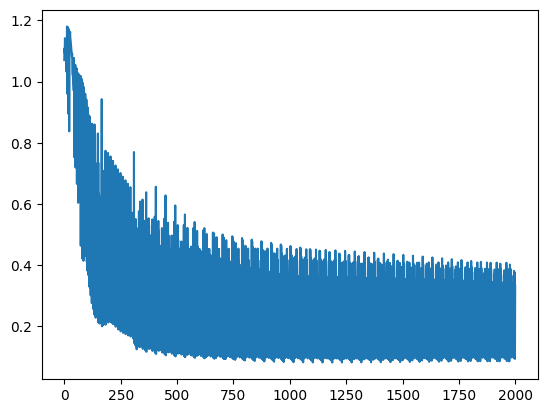

In [47]:
bot=Bot(strategy="kris")

model=create()

model,loss_history=fit(model)



In [55]:
generated,actual_history,win_or_lose=eval(model,bot,enable_random=True)

{'player_wins': 61, 'bot_wins': 39, 'tie': 0}
winrate==0.61
{'player_wins': 121, 'bot_wins': 79, 'tie': 0}
winrate==0.605
{'player_wins': 181, 'bot_wins': 119, 'tie': 0}
winrate==0.6033333333333334
{'player_wins': 241, 'bot_wins': 159, 'tie': 0}
winrate==0.6025
{'player_wins': 301, 'bot_wins': 199, 'tie': 0}
winrate==0.602
{'player_wins': 361, 'bot_wins': 239, 'tie': 0}
winrate==0.6016666666666667
{'player_wins': 421, 'bot_wins': 279, 'tie': 0}
winrate==0.6014285714285714
{'player_wins': 481, 'bot_wins': 319, 'tie': 0}
winrate==0.60125
{'player_wins': 541, 'bot_wins': 359, 'tie': 0}
winrate==0.6011111111111112
{'player_wins': 601, 'bot_wins': 399, 'tie': 0}
winrate==0.601


In [60]:
def get_initial(size,seed=42):
    np.random.seed(seed)
    s=""
    for i in range(size):
        s+=np.random.choice(["R","P","S"])
    return s

get_initial(8)


'SRSSRRSP'